# Импортим

In [5]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10369624522127804659
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1598571978151239352
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4706397784965176730
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11276946637
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13993282358854857746
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [0]:
import tensorflow as tf
import keras
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [0]:
import os
import random
import warnings
import numpy as np
import skimage.io
import skimage.transform

from matplotlib import pyplot as plt
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, Sequential
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from yellowbrick.target import ClassBalance
import keras
from keras import applications
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adadelta

In [0]:
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)
np.random.seed(1338) # 1337

# Все функции

In [0]:
def generator_error(generator):
    
    while True:
        try:
            x, y = next(generator)
            yield x, y
        except OSError:
            pass


def label_to_categorical(y):

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    y = to_categorical(y)

    return y


def files_per_directory(base_dir, categories):

    files_per_dir = []

    for category in categories:
        files = os.listdir(os.path.join(base_dir, category))
        files_per_dir.append(len(files))

    return files_per_dir


def load_images(base_dir, categories, shuffle=False, resize=False,
                size=(150, 150, 3), output_range=1000):
    
    file_list = []
    x = []
    y = []
    images_counter = 0
    errors_counter = 0
    c = 0
    cc = 0
    for category in categories:
        files = os.listdir(os.path.join(base_dir, category))
        for file in files:
                file_list.append((os.path.join(base_dir, category, file), category))

    if shuffle is True:
        random.shuffle(file_list)

    for ix, (data, label) in enumerate(file_list, start=1):
        try:
            image = skimage.io.imread(data)
            images_counter = ix
        except OSError:
            print(data)
            errors_counter += 1
            continue
        if resize:
            image = skimage.transform.resize(image, size, mode='reflect')
        x.append(image)
        y.append(label)

        if ix % output_range == 0:
            print('Images loaded: {} | Errors: {}'.format(ix, errors_counter))

    print('Total images loaded: {} | Total errors: {}'.format(images_counter,
                                                              errors_counter))

    x = np.array(x)
    y = np.array(y)

    return x, y


def statistic_diversification(files_per_dir, categories):

    for category, files in zip(categories, files_per_dir):
        print('{}: {} files'.format(category, files))


def statistic_samples_size_shape(array):

    print('''Samples {} | Batch size: {} | Shape {}'''.format(
        array.samples, array.batch_size, array.image_shape
    ))


def statistic_val_loss_acc(result):
    
    val_loss = min(result.history.get('val_loss'))
    val_acc = max(result.history.get('val_acc'))

    print('val_loss: {} | val_acc: {}'.format(
        val_loss, val_acc
    ))


def statistic_test_loss_acc(model, x, y=None, error=False):
    

    if y is not None:
        loss, acc = model.evaluate(x, y)
        print('test_loss: {} | test_acc: {}'.format(loss, acc))
    else:
        steps = x.samples // x.batch_size
        if error:
            loss, acc = model.evaluate_generator(generator_error(x),
                                                 steps=steps)
        else:
            steps = x.samples // x.batch_size
            loss, acc = model.evaluate_generator(x, steps=steps)

        print('test_loss: {} | test_acc: {}'.format(loss, acc))


def plot_diversification(files_per_dir, categories):


    plt.bar([x for x in range(len(files_per_dir))],
            files_per_dir, tick_label=categories)
    plt.show()


def plot_pic_per_category(base_dir, categories, size=(150, 150, 3)):

    fig, axes = plt.subplots(nrows=1, ncols=len(categories), figsize=(15, 3))

    for ix, category in enumerate(categories):
        directory = os.path.join(base_dir, category)
        first_image = os.listdir(directory)[1]

        try:
            image = skimage.io.imread(os.path.join(directory, first_image))
        except OSError:
            continue

        image = skimage.transform.resize(image, size, mode='reflect')
        axes[ix].imshow(image, resample=True)
        axes[ix].set_title(category)

    plt.show()


def plot_loss_acc(result, linestyle='-', result2=None, linestyle2=':'):
    acc = result.history['acc']
    val_acc = result.history['val_acc']
    loss = result.history['loss']
    val_loss = result.history['val_loss']
    epochs = range(1, len(acc) + 1)

    if result2:
        acc2 = result2.history['acc']
        val_acc2 = result2.history['val_acc']
        loss2 = result2.history['loss']
        val_loss2 = result2.history['val_loss']
        epochs2 = range(1, len(acc2) + 1)
    else:
        acc2 = 1
        val_acc2 = None
        loss2 = None
        val_loss2 = None
        epochs2 = None

    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(epochs, loss, color='green', linestyle=linestyle, marker='o',
             markersize=2, label='Training')
    plt.plot(epochs, val_loss, color='red', linestyle=linestyle, marker='o',
             markersize=2, label='Validation')
    if result2:
        plt.plot(epochs2, loss2, color='green', linestyle=linestyle2,
                 marker='o', markersize=2, label='Training')
        plt.plot(epochs2, val_loss2, color='red', linestyle=linestyle2,
                 marker='o', markersize=2, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(epochs, acc, color='green', linestyle=linestyle, marker='o',
             markersize=2, label='Training')
    plt.plot(epochs, val_acc, color='red', linestyle=linestyle, marker='o',
             markersize=2, label='Validation')
    if result2:
        plt.plot(epochs2, acc2, color='green', linestyle=linestyle2,
                 marker='o', markersize=2, label='Training')
        plt.plot(epochs2, val_acc2, color='red', linestyle=linestyle2,
                 marker='o', markersize=2, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [11]:
!unzip '/content/gdrive/My Drive/AAARRRTTT/dataset (1).zip' -d dataset

Archive:  /content/gdrive/My Drive/AAARRRTTT/dataset (1).zip
   creating: dataset/dataset_updated/
  inflating: dataset/dataset_updated/.DS_Store  
   creating: dataset/__MACOSX/
   creating: dataset/__MACOSX/dataset_updated/
  inflating: dataset/__MACOSX/dataset_updated/._.DS_Store  
   creating: dataset/dataset_updated/training_set/
   creating: dataset/dataset_updated/training_set/sculpture/
  inflating: dataset/dataset_updated/training_set/sculpture/63.jpg  
   creating: dataset/__MACOSX/dataset_updated/training_set/
   creating: dataset/__MACOSX/dataset_updated/training_set/sculpture/
  inflating: dataset/__MACOSX/dataset_updated/training_set/sculpture/._63.jpg  
  inflating: dataset/dataset_updated/training_set/sculpture/373.jpeg  
  inflating: dataset/__MACOSX/dataset_updated/training_set/sculpture/._373.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/189.jpg  
  inflating: dataset/__MACOSX/dataset_updated/training_set/sculpture/._189.jpg  
  inflating: datase

In [13]:
!unzip dataset/dataset_updated.zip -d data

unzip:  cannot find or open dataset/dataset_updated.zip, dataset/dataset_updated.zip.zip or dataset/dataset_updated.zip.ZIP.


In [16]:
!ls dataset/dataset_updated/training_set

drawings  engraving  iconography  painting  sculpture


## Подготовка даты

In [0]:
fake_ims

NameError: ignored

In [0]:
train_dir = 'dataset/dataset_updated/training_set'
test_dir = 'dataset/dataset_updated/validation_set/'

train_categories = [x for x in os.listdir(train_dir) if (x[0] is not '.')]
test_categories = [x for x in os.listdir(test_dir) if x[0] is not '.']

In [19]:
test_x, test_y = load_images(test_dir, test_categories, resize=True, output_range=100)

dataset/dataset_updated/validation_set/sculpture/106.jpg
Images loaded: 100 | Errors: 1
dataset/dataset_updated/validation_set/sculpture/170.jpg
Images loaded: 200 | Errors: 2
dataset/dataset_updated/validation_set/painting/1550.jpg
dataset/dataset_updated/validation_set/painting/1600.jpg
dataset/dataset_updated/validation_set/painting/2200.jpg
dataset/dataset_updated/validation_set/painting/1250.jpg
Images loaded: 300 | Errors: 6
dataset/dataset_updated/validation_set/painting/1150.jpg
dataset/dataset_updated/validation_set/painting/0300.jpg
dataset/dataset_updated/validation_set/painting/2225.jpg
Images loaded: 400 | Errors: 9
dataset/dataset_updated/validation_set/painting/2275.jpg
Images loaded: 500 | Errors: 10
Images loaded: 600 | Errors: 10
Images loaded: 700 | Errors: 10
Images loaded: 800 | Errors: 10
Total images loaded: 866 | Total errors: 10


In [20]:
train_x, train_y = load_images(train_dir, train_categories, resize=True)

dataset/dataset_updated/training_set/sculpture/200.jpg
dataset/dataset_updated/training_set/sculpture/374.jpg
dataset/dataset_updated/training_set/sculpture/210.jpg
dataset/dataset_updated/training_set/sculpture/190 18.59.45.jpg
dataset/dataset_updated/training_set/sculpture/168.jpg
dataset/dataset_updated/training_set/sculpture/261.jpg
Images loaded: 1000 | Errors: 6
dataset/dataset_updated/training_set/sculpture/107.jpg
dataset/dataset_updated/training_set/sculpture/.DS_Store
dataset/dataset_updated/training_set/painting/1625.jpg
dataset/dataset_updated/training_set/painting/1450.jpg
dataset/dataset_updated/training_set/painting/1900.jpg
dataset/dataset_updated/training_set/painting/2125.jpg
dataset/dataset_updated/training_set/painting/0950.jpg
dataset/dataset_updated/training_set/painting/1225.jpg
dataset/dataset_updated/training_set/painting/0525.jpg
Images loaded: 2000 | Errors: 15
dataset/dataset_updated/training_set/painting/0625.jpg
dataset/dataset_updated/training_set/paintin

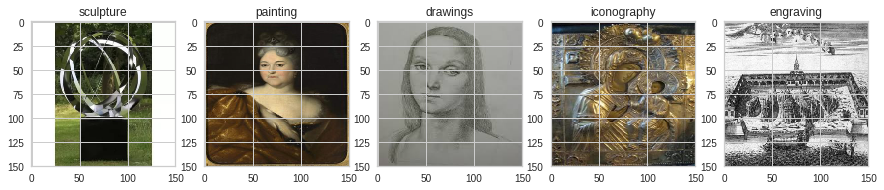

In [21]:
plot_pic_per_category(train_dir, train_categories)

In [22]:
train_files_per_dir = files_per_directory(train_dir, train_categories)
statistic_diversification(train_files_per_dir, train_categories)

sculpture: 1746 files
painting: 2129 files
drawings: 1108 files
iconography: 2080 files
engraving: 761 files


In [23]:
test_files_per_dir = files_per_directory(test_dir, train_categories)
statistic_diversification(test_files_per_dir, test_categories)

sculpture: 193 files
painting: 236 files
drawings: 122 files
iconography: 231 files
engraving: 84 files


In [0]:
train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y, test_size=0.2, random_state=1338, stratify=train_y
)

In [0]:
epochs=70
patience=20

In [0]:
train_y = label_to_categorical(train_y)
val_y = label_to_categorical(val_y)
test_y = label_to_categorical(test_y)

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=90,      
    horizontal_flip=True,    
    vertical_flip=True,
    zoom_range=0.4)

train_datagen.fit(train_x)

train_generator = train_datagen.flow(train_x, 
                                     train_y, 
                                     batch_size=64, 
                                     seed=1338)

In [28]:
train_x.shape

(6176, 150, 150, 3)

## model

In [0]:
mode = input()
if mode == 'resnet':
    from keras.applications import resnet50
    from keras.models import Model
    from keras.layers import Dense, GlobalAveragePooling2D, Dropout
    from keras import backend as K
    import keras 

    base_model = keras.applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, 
                                                input_shape= (150,150,3), )


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation= 'relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation= 'softmax')(x)
    model = Model(inputs = base_model.input, outputs = predictions)
else:
    model = Sequential()
    model.add(Conv2D(input_shape=(150, 150, 3), activation='relu'))
    mode.add(MaxPooling2D(2, 2))


In [37]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adadelta(),
    metrics=['accuracy']
)


In [0]:
weights_file = 'flash2.h5'
model_file = 'RESNET_JS.json'

In [0]:

result = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=(val_x, val_y),
    steps_per_epoch=150,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            mode='auto', 
            verbose=1, 
            patience=patience+2,
        ), 
        ModelCheckpoint(
            weights_file, 
            monitor='val_loss', 
            mode='auto', 
            save_best_only=True, 
            verbose=1,
        ),
    ]
)

Epoch 1/70
150/150 [==============================] - 170s 1s/step - loss: 0.6483 - acc: 0.7970 - val_loss: 2.4257 - val_acc: 0.5573

Epoch 00001: val_loss improved from inf to 2.42572, saving model to flash2.h5
Epoch 2/70
150/150 [==============================] - 151s 1s/step - loss: 0.4953 - acc: 0.8519 - val_loss: 1.4905 - val_acc: 0.6809

Epoch 00002: val_loss improved from 2.42572 to 1.49050, saving model to flash2.h5
Epoch 3/70
150/150 [==============================] - 151s 1s/step - loss: 0.3744 - acc: 0.8712 - val_loss: 1.3991 - val_acc: 0.7385

Epoch 00003: val_loss improved from 1.49050 to 1.39905, saving model to flash2.h5
Epoch 4/70
150/150 [==============================] - 151s 1s/step - loss: 0.3184 - acc: 0.8869 - val_loss: 0.7762 - val_acc: 0.7761

Epoch 00004: val_loss improved from 1.39905 to 0.77624, saving model to flash2.h5
Epoch 5/70
150/150 [==============================] - 151s 1s/step - loss: 0.3136 - acc: 0.8876 - val_loss: 2.7340 - val_acc: 0.5262

Epoch 

# results

In [0]:
statistic_val_loss_acc(result)

In [0]:
plot_loss_acc(result)

In [0]:

model= load_model(weights_file)
statistic_test_loss_acc(model, test_x, test_y)

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open(model_file, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(weights_file)
print("Saved model to disk")